In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [2]:
def grade_rates(scores):
    grades = scores.columns[2::2]
    counts_grades = np.array([scores.iloc[:, 2:][grade].value_counts(bins=[-0.5, 0.5, 1.5, 2.5, 3.5], sort=False) for grade in grades])
    total_counts_grades = (np.sum(counts_grades, axis=0))
    return total_counts_grades / np.sum(total_counts_grades)

def case_rates(scores):
    cases = scores.columns[3::2]
    counts_cases = np.array([scores.iloc[:, 2:][case].value_counts(bins=[-0.5, 0.5, 1.5, 2.5, 3.5], sort=False) for case in cases])
    total_counts_cases = (np.sum(counts_cases, axis=0))
    return total_counts_cases / np.sum(total_counts_cases)

In [36]:
def plot_statistics(scores, title, lower=False):
    grades = scores.columns[2::2]

    # per vertebrae statistics
    counts_grades = np.array([scores.iloc[:, 2:][grade].value_counts(bins=[-0.5, 0.5, 1.5, 2.5, 3.5], sort=False) for grade in grades])
    
    # total statistics
    total_counts_grades = (np.sum(counts_grades, axis=0))

    sns.set_style("dark")
    index = np.asarray(['T{}'.format(i) for i in range(1, 13)] + ['L{}'.format(i) for i in range(1, 7)])
    df = pd.DataFrame({'Grade 0: Healthy': counts_grades[:, 0], 
                       'Grade 1: Mild': counts_grades[:, 1],
                       'Grade 2: Moderate': counts_grades[:, 2],
                       'Grade 3: Severe': counts_grades[:, 3]}, index=index)
    bars = df.plot.bar(figsize=(25, 8), width=0.75, alpha=0.75, fontsize=15, rot=0)
    plt.ylabel('Number of Occurrences', fontsize=16)
    plt.title('Distribution of grades among the vertebrae in {}'.format(title), fontsize=16)
    plt.legend(fontsize=16, loc='upper right', bbox_to_anchor=(1.1, 1.1)) 
    plt.gca().yaxis.grid()

    # plot the counts on top
    for i, p in enumerate(bars.patches):
        x = (p.get_x() + p.get_width() // 2)
        x = x + 0.03 if (i % 4) != 0 else x
        y = p.get_y() + p.get_height() + 1
        if lower:
            y = p.get_y() + p.get_height() + 0.2
        bars.annotate(counts_grades.T.flatten()[i], (x, y))

    # plt.savefig('plots/distibution_grades.png', bbox_inches='tight')
    plt.show()

In [4]:
def plot_dist_grade_case(scores):
    grade = grade_rates(scores)
    case = case_rates(scores)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,8))
    df = pd.DataFrame({'Grade 0: Healthy': grade[0], 
                       'Grade 1: Mild': grade[1],
                       'Grade 2: Moderate': grade[2],
                       'Grade 3: Severe': grade[3]}, index=[''])

    bars = df.plot.bar(width=0.2, alpha=0.75, ax=axes[0])

    df = pd.DataFrame({'Case 0: Healthy': case[0], 
                       'Case 1: Wedge': case[1],
                       'Case 2: Concave': case[2],
                       'Case 3: Crush': case[3]}, index=[''])
    bars = df.plot.bar(width=0.2, alpha=0.75, ax=axes[1])
    
    plt.suptitle('Distribution of grades and cases')
    plt.tight_layout()
    plt.show()

The measurements are in "markers". There is one text file per scan and each line is one measurement.

* The first three values are the x/y/z coordinates
* The fourth is the label of the vertebra
* The next three are probably the vector that was measured
 so the observers clicked on a point at the top of the vertebra and drew a line to the bottom of the vertebra; the x/y/z coordinate is the point at the top and x/y/z + the vector gives you the point at the bottom. 
 But if you only want the height you can simply compute the length of the      vector.
* The last value in each row is the position of the measurements, probably 1 is anterior, 2 in the middle of the vertebral body and 3 posterior.


In [5]:
nlst_data_path = '/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/nlst/' 
image_dir = os.path.join(nlst_data_path, 'images_normal', 'mha', 'images')
marker_dir = os.path.join(nlst_data_path, 'markers')

# ids of normal images
ids = [filename[:-4] for filename in sorted(os.listdir(image_dir))]

def length(m):
    """Computes the length of a measurement."""
    vec = [float(item) for item in m[4:7]]
    return np.linalg.norm(vec)

cases = []
    
for ID in ids:
    file = open(os.path.join(marker_dir, ID) + '.txt', 'r')
    measurements = [m.split(' ')[:-1] for m in file.read().split('\n')][:-1]
    data = []
    
    for a, m, p,  in zip(*[iter(measurements)] * 3):
        vert = int(float(a[3]))
        h_a, h_m, h_p = length(a), length(m), length(p)
        data.append({'vert': vert, 'h_a': h_a, 'h_m': h_m, 'h_p': h_p})
        
    # loop over vertebrae, compute ratio posterior wall ratio with adjacent (=hpa)
    for i, vert in enumerate(data):
        if i == 0:
            data[i]['h_pa'] = data[i + 1]['h_p']             # no prev vert => only take the height of the next posterior wall
        elif i == len(data) - 1:  
            data[i]['h_pa'] = data[i - 1]['h_p']             # no next vert => only take the height of the prev posterior wall
        else:
            data[i]['h_pa'] = (data[i - 1]['h_p'] + data[i + 1]['h_p']) / 2  # if both are present we average the height of those two posterior walls
            
        # compute ratios: APR, MPR, HPR
        data[i]['apr'] = data[i]['h_a'] / data[i]['h_p']      
        data[i]['mpr'] = data[i]['h_m'] / data[i]['h_p']
        data[i]['hpr'] = data[i]['h_p'] / data[i]['h_pa']    
        
        # compute grade and case
        ratios = [data[i]['apr'], data[i]['mpr'], data[i]['hpr']]
        min_ratio, case = np.min(ratios), np.argmin(ratios) + 1
    
        """
        0  - 20% => healthy
        20 - 25% => mild
        25 - 40% => moderate
        > 40%    => severe
        """
        
        if min_ratio > 0.80:
            data[i]['grade'] = 0
            data[i]['case'] = 0
        elif min_ratio > 0.75:
            data[i]['grade'] = 1
            data[i]['case'] = case
        elif min_ratio > 0.60:
            data[i]['grade'] = 2
            data[i]['case'] = case
        else:
            data[i]['grade'] = 3
            data[i]['case'] = case
                  
    data = pd.DataFrame(data)
    cases.append({'id': ID, 'df': data})

In [6]:
for case in cases[:10]:
    print('ID: {}'.format(case['id']))
    display(case['df'])

ID: 1.2.840.113654.2.55.10259023798877956221151571137018894643


,vert,h_a,h_m,h_p,h_pa,apr,mpr,hpr,grade,case
0,8,16.648492,14.989677,18.236494,19.860506,0.912922,0.821960,0.918229,0,0
1,9,17.549109,16.874129,19.860506,19.126200,0.883618,0.849632,1.038393,0,0
2,10,18.422950,18.824130,20.015906,20.723363,0.920415,0.940459,0.965862,0,0
3,11,20.428131,18.903778,21.586220,20.607255,0.946351,0.875734,1.047506,0,0
4,12,19.952044,19.285610,21.198604,21.225638,0.941196,0.909759,0.998726,0,0
5,13,18.891832,19.121873,20.865056,21.804553,0.905429,0.916454,0.956913,0,0
6,14,19.924586,20.862867,22.410502,20.422223,0.889074,0.930942,1.097359,0,0
7,15,19.320957,18.724634,19.979390,22.528775,0.967044,0.937198,0.886839,0,0
8,16,20.233208,21.741883,22.647048,22.796261,0.893415,0.960032,0.993454,0,0
9,17,23.138631,23.437885,25.613133,24.406333,0.903389,0.915073,1.049446,0,0


ID: 1.2.840.113654.2.55.105103222666922550500414066350839234032


,vert,h_a,h_m,h_p,h_pa,apr,mpr,hpr,grade,case
0,8,17.663287,17.557779,18.829495,20.491301,0.938065,0.932461,0.918902,0,0
1,9,19.865890,17.905748,20.491301,19.273278,0.969479,0.873822,1.063198,0,0
2,10,19.372710,18.098541,19.717060,21.015071,0.982535,0.917913,0.938234,0,0
3,11,19.594030,19.343734,21.538842,21.121192,0.909707,0.898086,1.019774,0,0
4,12,21.278509,20.180943,22.525324,22.661144,0.944648,0.895922,0.994006,0,0
5,13,20.252090,20.415877,23.783446,22.543963,0.851520,0.858407,1.054981,0,0
6,14,20.139270,20.139270,22.562602,22.755137,0.892595,0.892595,0.991539,0,0
7,15,20.415890,19.860565,21.726828,23.401474,0.939663,0.914103,0.928438,0,0
8,16,22.105929,21.551855,24.240345,23.365172,0.911948,0.889090,1.037456,0,0
9,17,24.041393,23.187871,25.003517,25.339491,0.961520,0.927384,0.986741,0,0


ID: 1.2.840.113654.2.55.105265501367167886697178234304413067731


,vert,h_a,h_m,h_p,h_pa,apr,mpr,hpr,grade,case
0,9,19.371329,18.116748,18.172668,20.259274,1.065960,0.996923,0.897005,0,0
1,10,18.791520,17.537847,20.259274,19.835084,0.927551,0.865670,1.021386,0,0
2,11,19.760462,18.098031,21.497500,20.351546,0.919198,0.841867,1.056308,0,0
3,12,13.629512,9.285216,20.443818,20.832383,0.666681,0.454182,0.981348,3,2
4,13,17.783082,17.758323,20.167267,21.420053,0.881779,0.880552,0.941513,0,0
5,14,18.217332,18.209900,22.396288,20.102461,0.813409,0.813077,1.114107,0,0
6,15,17.949700,18.471831,20.037656,23.171004,0.895798,0.921856,0.864773,0,0
7,16,21.593267,20.812925,23.945720,23.941847,0.901759,0.869171,1.000162,0,0
8,17,20.817803,23.672900,27.846038,26.042121,0.747604,0.850135,1.069269,2,1
9,18,23.955612,23.968319,28.138521,28.072019,0.851346,0.851797,1.002369,0,0


ID: 1.2.840.113654.2.55.105395429683478748517708950555878353025


,vert,h_a,h_m,h_p,h_pa,apr,mpr,hpr,grade,case
0,8,16.350350,15.223037,17.234378,19.688054,0.948706,0.883295,0.875372,0,0
1,9,19.470046,17.278727,19.688054,19.190009,0.988927,0.877625,1.025953,0,0
2,10,19.362970,18.407029,21.145640,20.276214,0.915696,0.870488,1.042879,0,0
3,11,21.109461,19.131815,20.864374,21.337116,1.011747,0.916961,0.977844,0,0
4,12,21.109489,19.221241,21.528592,21.116527,0.980533,0.892824,1.019514,0,0
5,13,20.075096,17.638078,21.368680,21.821883,0.939464,0.825417,0.979232,0,0
6,14,18.974924,19.296938,22.115175,22.067010,0.858005,0.872565,1.002183,0,0
7,15,19.745375,20.803115,22.765340,22.400937,0.867344,0.913806,1.016267,0,0
8,16,21.066200,20.797854,22.686700,23.967481,0.928570,0.916742,0.946562,0,0
9,17,22.187633,22.161315,25.169621,25.419268,0.881524,0.880479,0.990179,0,0


ID: 1.2.840.113654.2.55.107122807925119558582842877714412436508


,vert,h_a,h_m,h_p,h_pa,apr,mpr,hpr,grade,case
0,9,17.304836,16.272668,17.375846,19.323501,0.995913,0.936511,0.899208,0,0
1,10,18.925674,17.591708,19.323501,18.528265,0.979412,0.910379,1.042920,0,0
2,11,18.156271,16.665947,19.680684,19.862248,0.922543,0.846817,0.990859,0,0
3,12,20.314447,19.708131,20.400994,20.608275,0.995758,0.966038,0.989942,0,0
4,13,20.591023,20.489649,21.535866,21.587647,0.956127,0.951420,0.997601,0,0
5,14,19.235687,21.253715,22.774299,20.839062,0.844623,0.933232,1.092866,0,0
6,15,19.810005,19.397907,20.142257,23.044935,0.983505,0.963045,0.874043,0,0
7,16,20.235971,20.848068,23.315571,22.326105,0.867917,0.894169,1.044319,0,0
8,17,21.978954,21.783598,24.509954,24.075051,0.896736,0.888765,1.018064,0,0
9,18,24.858707,24.162747,24.834532,24.687363,1.000973,0.972950,1.005961,0,0


ID: 1.2.840.113654.2.55.108786155866146748415911757393797039822


,vert,h_a,h_m,h_p,h_pa,apr,mpr,hpr,grade,case
0,9,19.926290,20.113033,21.712642,21.992083,0.917728,0.926328,0.987294,0,0
1,10,20.782524,21.286409,21.992083,21.366167,0.945000,0.967912,1.029295,0,0
2,11,21.729087,19.348086,21.019691,21.726678,1.033749,0.920474,0.967460,0,0
3,12,18.237081,19.318246,21.461273,22.312097,0.849767,0.900144,0.961867,0,0
4,13,18.773159,20.643741,23.604503,23.207811,0.795321,0.874568,1.017093,1,1
5,14,22.256960,20.910000,24.954349,24.436741,0.891907,0.837930,1.021182,0,0
6,15,20.727118,21.795339,25.268979,25.681186,0.820259,0.862533,0.983949,0,0
7,16,24.872110,24.780832,26.408023,26.965928,0.941839,0.938383,0.979311,0,0
8,17,26.733951,25.047672,28.662877,28.583443,0.932703,0.873872,1.002779,0,0
9,18,29.161390,29.161390,30.758864,28.662877,0.948065,0.948065,1.073126,0,0


ID: 1.2.840.113654.2.55.109606478879143417399892756584691409986


,vert,h_a,h_m,h_p,h_pa,apr,mpr,hpr,grade,case
0,9,19.874003,19.525620,20.652317,20.271327,0.962313,0.945445,1.018795,0,0
1,10,20.876855,19.421393,20.271327,21.287095,1.029871,0.958072,0.952282,0,0
2,11,21.688713,21.607557,21.921873,21.215095,0.989364,0.985662,1.033315,0,0
3,12,21.784589,22.202003,22.158863,23.471643,0.983110,1.001947,0.944070,0,0
4,13,23.207051,23.233478,25.021414,23.441256,0.927488,0.928544,1.067409,0,0
5,14,21.341878,21.768852,24.723650,24.799340,0.863217,0.880487,0.996948,0,0
6,15,21.029725,22.406880,24.577266,24.092430,0.855658,0.911691,1.020124,0,0
7,16,21.326232,21.836646,23.461211,24.831637,0.909000,0.930755,0.944811,0,0
8,17,24.563366,24.689634,25.086008,23.949464,0.979166,0.984199,1.047456,0,0
9,18,24.564947,24.190993,24.437718,25.539142,1.005206,0.989904,0.956873,0,0


ID: 1.2.840.113654.2.55.113344251698626794149589455429707137228


,vert,h_a,h_m,h_p,h_pa,apr,mpr,hpr,grade,case
0,8,20.333716,17.884630,20.169284,21.875329,1.008153,0.886726,0.922011,0,0
1,9,20.333716,18.672440,21.875329,20.662567,0.929527,0.853584,1.058694,0,0
2,10,20.736924,19.080094,21.155850,22.704779,0.980198,0.901883,0.931780,0,0
3,11,21.759825,21.181360,23.534230,22.406070,0.924603,0.900023,1.050351,0,0
4,12,20.665188,20.665188,23.656289,23.544742,0.873560,0.873560,1.004738,0,0
5,13,20.455073,20.734753,23.555254,23.836579,0.868387,0.880260,0.988198,0,0
6,14,22.202027,22.500000,24.016869,23.777627,0.924435,0.936842,1.010062,0,0
7,15,23.101948,20.400000,24.000000,24.309349,0.962581,0.850000,0.987274,0,0
8,16,22.232409,22.502000,24.601829,25.650824,0.903689,0.914647,0.959105,0,0
9,17,24.307406,24.316661,27.301648,27.391392,0.890327,0.890666,0.996724,0,0


ID: 1.2.840.113654.2.55.11454259044234168537457753210370760209


,vert,h_a,h_m,h_p,h_pa,apr,mpr,hpr,grade,case
0,9,19.902434,18.416461,22.479022,23.640943,0.885378,0.819273,0.950851,0,0
1,10,21.538184,19.176286,23.640943,23.267234,0.911054,0.811147,1.016062,0,0
2,11,23.953245,21.357789,24.055447,23.909685,0.995751,0.887857,1.006096,0,0
3,12,25.222450,22.385685,24.178426,24.570184,1.043180,0.925854,0.984056,0,0
4,13,24.173762,21.982373,25.084921,24.018243,0.963677,0.876318,1.044411,0,0
5,14,25.201118,22.718569,23.858059,24.589507,1.056294,0.952239,0.970254,0,0
6,15,23.818300,23.133587,24.094093,24.205756,0.988553,0.960135,0.995387,0,0
7,16,24.820216,21.531131,24.553453,24.507087,1.010865,0.876908,1.001892,0,0
8,17,26.852847,24.232864,24.920080,25.945885,1.077559,0.972423,0.960464,0,0
9,18,27.191004,27.181490,27.338317,26.498445,0.994611,0.994263,1.031695,0,0


ID: 1.2.840.113654.2.55.114918217361496660856069360878436211830


,vert,h_a,h_m,h_p,h_pa,apr,mpr,hpr,grade,case
0,8,18.728487,18.278584,20.436527,20.298561,0.916422,0.894408,1.006797,0,0
1,9,20.466001,18.057850,20.298561,20.611765,1.008249,0.889612,0.984805,0,0
2,10,20.731027,19.646066,20.787002,21.123975,0.997307,0.945113,0.984048,0,0
3,11,19.996774,19.256399,21.949390,21.261930,0.911040,0.877309,1.032333,0,0
4,12,20.650334,20.541813,21.736858,22.005308,0.950015,0.945022,0.987801,0,0
5,13,21.218078,21.132139,22.061226,22.025664,0.961781,0.957886,1.001615,0,0
6,14,21.733372,21.544963,22.314470,23.380666,0.973959,0.965515,0.954398,0,0
7,15,24.015900,23.361820,24.700106,23.238519,0.972299,0.945819,1.062895,0,0
8,16,24.509370,23.416875,24.162569,24.625842,1.014353,0.969138,0.981187,0,0
9,17,26.024419,23.971086,24.551579,25.851950,1.059990,0.976356,0.949699,0,0


In [8]:
# columns in my scoresheet format
T_columns = [list(a) for a in zip(['T{} grade'.format(i) for i in range(1, 13)], ['T{} case'.format(i) for i in range(1, 13)])]
L_columns = [list(a) for a in zip(['L{} grade'.format(i) for i in range(1, 7)], ['L{} case'.format(i) for i in range(1, 13)])]
columns = ['Dataset', 'ID'] + sum(T_columns, []) + sum(L_columns, [])

# make the score sheet
nlst_scores = pd.DataFrame()

for case in cases:
    verts_present = list(case['df']['vert']) 

    score_row = []
    for i, vert in enumerate(range(8, 26)):
        if vert in verts_present:
            g = float(case['df'][case['df']['vert'] == vert]['grade'])
            c = float(case['df'][case['df']['vert'] == vert]['case'])
        else:
            g = float('nan')
            c = float('nan')
            
        score_row.append(g)
        score_row.append(c)

    row_list = ['nlst', case['id']] + score_row
    row = pd.DataFrame([row_list], columns=columns)
    nlst_scores = nlst_scores.append(row, ignore_index=True)
    
display(nlst_scores)
# nlst_scores.to_csv('/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/nlst/scores.csv', header=True, index=False)

,Dataset,ID,T1 grade,T1 case,T2 grade,T2 case,T3 grade,T3 case,T4 grade,T4 case,...,L2 grade,L2 case,L3 grade,L3 case,L4 grade,L4 case,L5 grade,L5 case,L6 grade,L6 case
0,nlst,1.2.840.113654.2.55.10259023798877956221151571137018894643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,nlst,1.2.840.113654.2.55.105103222666922550500414066350839234032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,nlst,1.2.840.113654.2.55.105265501367167886697178234304413067731,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,nlst,1.2.840.113654.2.55.105395429683478748517708950555878353025,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nlst,1.2.840.113654.2.55.107122807925119558582842877714412436508,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,nlst,1.3.6.1.4.1.14519.5.2.1.7009.9004.870364740345702555666778252712,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
369,nlst,1.3.6.1.4.1.14519.5.2.1.7009.9004.870404396611456484442321135144,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
370,nlst,1.3.6.1.4.1.14519.5.2.1.7009.9004.962328191231587020944306145414,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
371,nlst,1.3.6.1.4.1.14519.5.2.1.7009.9004.978957874101674915127722046362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
verse_scores = pd.read_csv('/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/verse2019/scores.csv')
xvertseg_scores = pd.read_csv('/mnt/netcache/bodyct/experiments/vertebra_fracture_detection_t9560/datasets/xvertseg/scores.csv')
all_scores = xvertseg_scores.append(verse_scores)

In [49]:
print("Grades")
print("NLST")
print(grade_rates(nlst_scores))
print("Verse")
print(grade_rates(verse_scores))
print(" ")
print("Cases")
print("NLST")
print(case_rates(nlst_scores))
print("Verse")
print(case_rates(verse_scores))
print(" ")
# print("NLST")
# plot_dist_grade_case(nlst_scores)
# print("Verse")
# plot_dist_grade_case(verse_scores)

Grades
NLST
[0.94334975 0.04276758 0.0127631  0.00111957]
Verse
[0.80326383 0.0942883  0.06708976 0.03535811]
 
Cases
NLST
[0.94334975 0.02686968 0.02866099 0.00111957]
Verse
[0.80326383 0.07615594 0.09610154 0.02447869]
 


In [46]:
train_percent=0.8 
val_percent=0.1

IDs = np.arange(135)
np.random.seed(1993)
np.random.shuffle(IDs)

N = len(IDs)
n_train_end = int(train_percent * N)
n_val_end = int(val_percent * N) + n_train_end
train_ids = IDs[:n_train_end]
val_ids = IDs[n_train_end:n_val_end]
test_ids = IDs[n_val_end:]

train_scores = all_scores.iloc[train_ids]
val_scores = all_scores.iloc[val_ids]
test_scores = all_scores.iloc[test_ids]

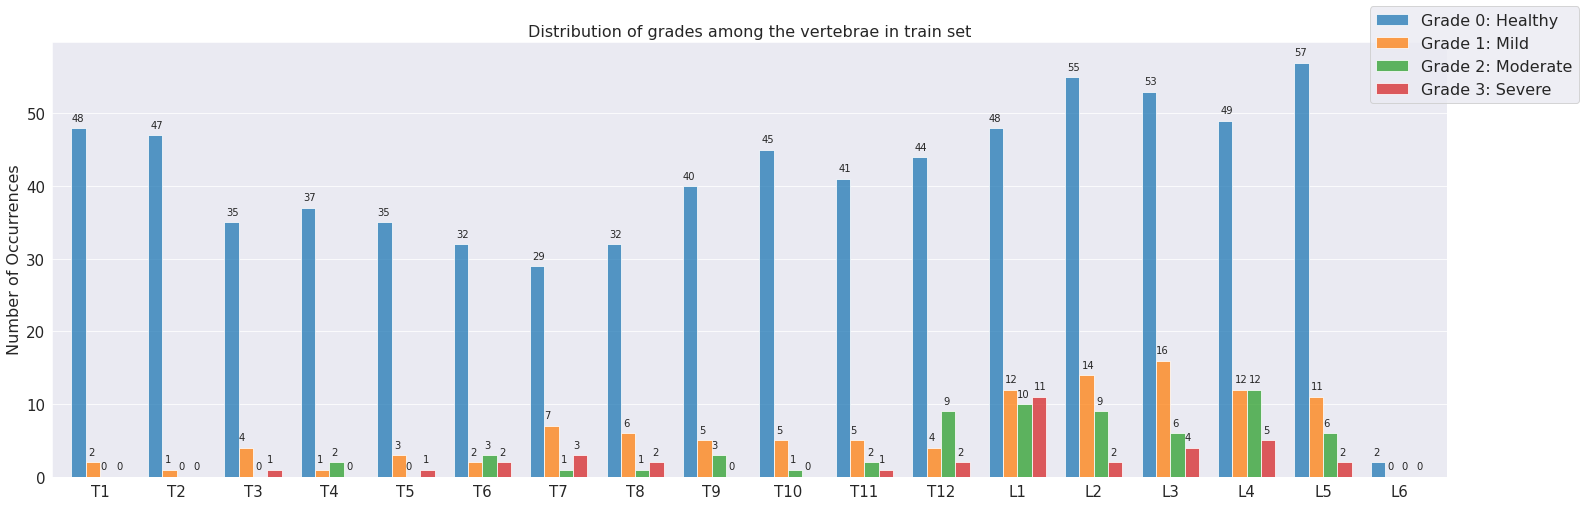

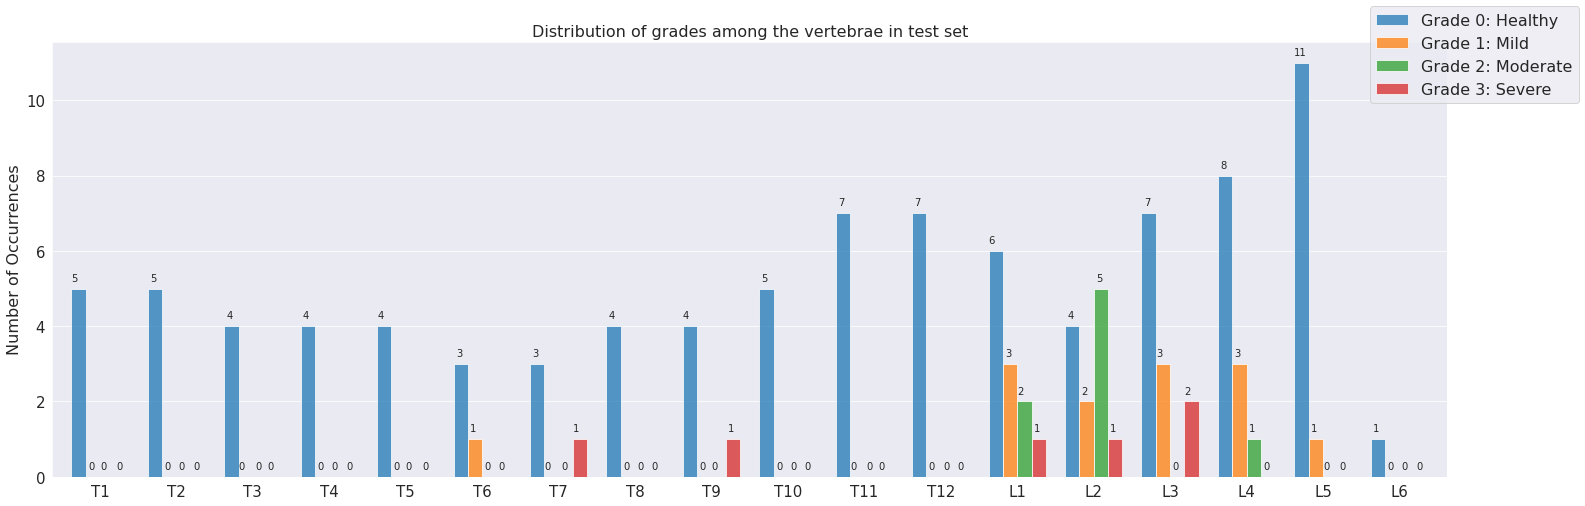

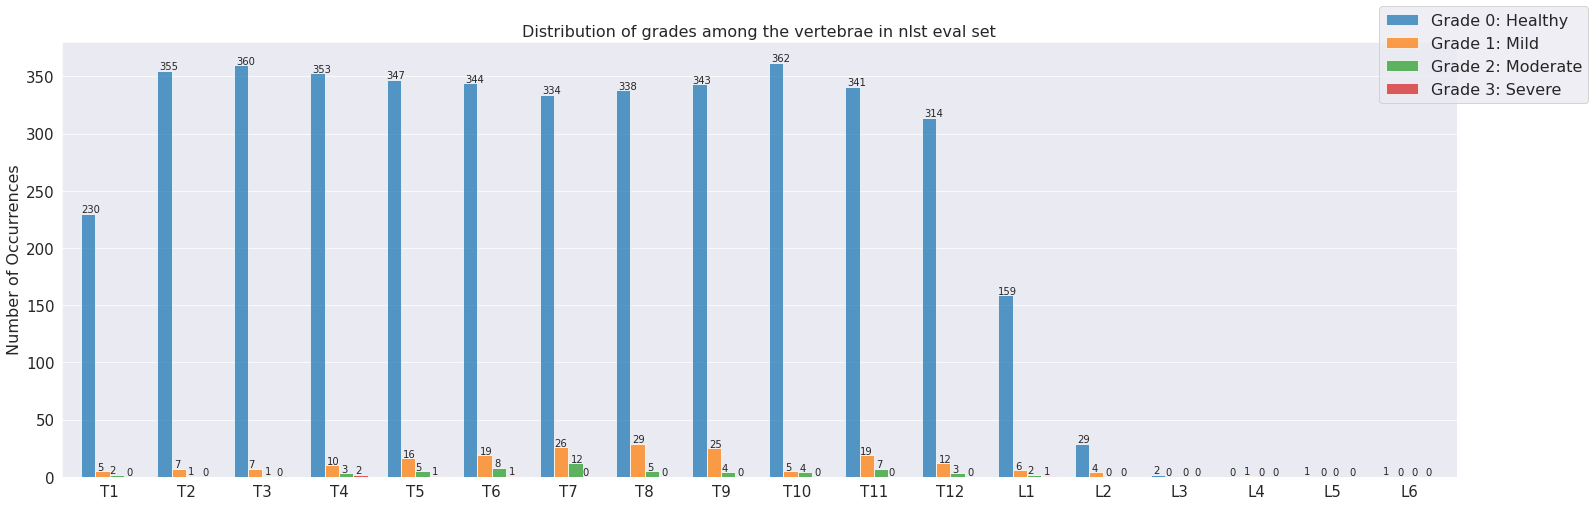

In [47]:
plot_statistics(train_scores, title='train set')
plot_statistics(test_scores, title='test set', lower=True)
plot_statistics(nlst_scores, title='nlst eval set')